# Introduction

### Problem Description

The problem of [surrogate modelling](https://en.wikipedia.org/wiki/Surrogate_model) is as follows. There are several control variables that can be changed by a decision maker and the goal is to find optimal vector of control variables' values, but a loss to be minimized is hard to measure and so its values are available only on limited amount of control variables' vectors. The approach of surrogate modelling lies in building a model that approximates the loss function on the whole set of available inputs and is based on available data. Then a minimum point of loss function's approximation is regarded as minimum point of real loss.

Let us provide an example of situation where surrogate modelling is appropriate. Suppose that engineers are going to create new alloy of two metals and these engineers have two control variables: proportion of one metal to the other and intensity of heat treatment. Assume also that a loss is fragility of alloy. Engineers can produce pieces of various alloys that are obtained with several values of control variables and test them empirically, but this procedure is expensive. After some data are gathered, it is possible to build an approximation of fragility function and then test an alloy that corresponds to its minimum point.

In this notebook, machine learning approach is used for surrogate modelling of some functions of two variables. Note that tree-based ensembles are not involved here, because they can not make a prediction that is below target's minimum over training sample or above target's maximum over training sample and, in particular, they can not extrapolate trends.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import keras

Using TensorFlow backend.


In [ ]:
np.random.seed(361)

# Template of Experiments

### Designs of Experiments

Since functions of just two arguments are studied here, there is no curse of dimensionality. Hence, complex designs such as [Latin hypercubes](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol sequences](https://en.wikipedia.org/wiki/Sobol_sequence), or [Halton sequences](https://en.wikipedia.org/wiki/Halton_sequence) are not necessary. Only two designs are used:
* Random sampling from uniform distribution on a constrained segment of domain;
* Grid of particular size and equal steps. 

In [2]:
def draw_from_uniform_distribution(n_samples, x_borders, y_borders):
    """
    @type n_samples: int
    @type x_borders: tuple(float)
    @type y_borders: tuple(float)
    @rtype: numpy.ndarray
    """
    xs = np.random.uniform(x_borders[0], x_borders[1], n_samples).reshape((-1, 1))
    ys = np.random.uniform(y_borders[0], y_borders[1], n_samples).reshape((-1, 1))
    return np.hstack((xs, ys))

In [22]:
def create_grid(step, left_bottom_corner, x_n_steps, y_n_steps):
    """
    @type step: float
    @type left_bottom_corner: tuple(float)
    @type x_n_steps: int
    @type y_n_steps: int
    @rtype: numpy.ndarray
    """
    xs = [left_bottom_corner[0] + i * step for i in range(x_n_steps)]
    ys = [left_bottom_corner[1] + i * step for i in range(y_n_steps)]
    return np.transpose([np.tile(xs, len(ys)), np.repeat(ys, len(xs))])

### Runner

TODO: for each capacity of xgboost and number of observations compute average cross-validation error and average score in estimated minimum over multiple runs as well as KDE of estimated minimums.

TODO: Pass design of experiment as a string argument that is matched to a function.

TODO: Two benchmarks - random guessing over all square and taking a minimum point over training sample (note that there is noise in measured targets).

# Experiments

### Himmelblau's Function and Random DoE

[Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function) is: $$f(x, y) = (x^2+y-11)^2 + (x+y^2-7)^2.$$

Here it is chosen as an example of non-convex function with multiple global minima.

In [34]:
def noisy_himmelblaus_function(x, y, noise_stddev=0):
    """
    Computes Himmelblau's function at
    point (`x`, `y`) and adds some
    Gaussian noise.
    
    @type x: float
    @type y: float
    @rtype: float
    """
    himmelblaus_value = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    noise = np.random.normal(scale=noise_stddev, size=1)[0]
    return himmelblaus_value + noise

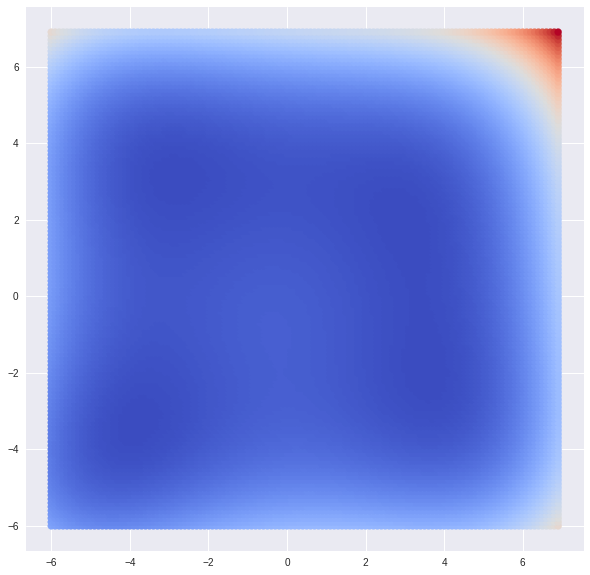

In [36]:
# TODO: Plot actual loss in one axes and surrogate loss in other axes.
df = pd.DataFrame(create_grid(0.1, [-6, -6], 130, 130), columns=['x', 'y'])
df['z'] = df.apply(lambda row: noisy_himmelblaus_function(row['x'], row['y'], 0.2), axis=1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
_ = ax.scatter(df['x'], df['y'], c=df['z'], cmap='coolwarm')

# Conclusion

To be continued.